**Computer Vision Screening Task**
Image Classification Model
---



This is for a task given by AccioAI.

Document verification has been a tedious and mandatory task in a lot of companies. With
increasing strictness in rules and regulations imposed by our government, it has become
mandatory for companies to maintain and update KYC information for their customers on a
regular basis. Thanks to increasing digitization, we are now able to automate many tasks in this
field.
Below is a CNN algorithm for water detection on photos of faces.
I have used a Pytorch based library called Fastai.

In [0]:
import fastai
import numpy as np
from fastai.metrics import accuracy
from fastai.vision import *

I have imported the required libraries to be used for our task.

In [0]:
from google.colab import drive

Data has been uploaded on google drive.
I have downloaded around 200 images from Google images consisting of watermarked images of faces as well as without watermarked ones. Some of the data provided by AccioAI has also been used for the training.

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/data/'

Now, we can ask the fast.ai to load all the data. I use from_folder function from class ImageDataBunch.

In [0]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2, train = 'train', test = 'test',ds_tfms=get_transforms(), size=250, num_workers=4).normalize(imagenet_stats)

I asked the function to not only load the data, but make two transformations.
Firstly, it will do data augmentation by flipping the pictures horizontally, making some rotations and zoomings. By doing so, it can supply the model with more training data, and prevent the model from overfitting.
Secondly, it will set the size of each image to 250 x 250.

In [0]:
data.train_ds, data.valid_ds, data.test_ds

(LabelList (260 items)
 x: ImageList
 Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
 y: CategoryList
 raw,raw,raw,raw,raw
 Path: /content/drive/My Drive/data, LabelList (64 items)
 x: ImageList
 Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
 y: CategoryList
 raw,raw,raw,water,raw
 Path: /content/drive/My Drive/data, LabelList (71 items)
 x: ImageList
 Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
 y: EmptyLabelList
 ,,,,
 Path: /content/drive/My Drive/data)

Training data consists of 260 images, half watermarked and half raw pictures. Validation data consists of 64 images.
In addition, test data has 71 images for prediction.

In [0]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds))


['raw', 'water'] 2 260 64 71


In [0]:
defaults.device = torch.device('cuda') # makes sure the gpu is used

It detects classes automatically as the images have been stored in separate folders named 'raw' and 'water' representing standard and watermarked images respectively.
Let's view some random images from our data.

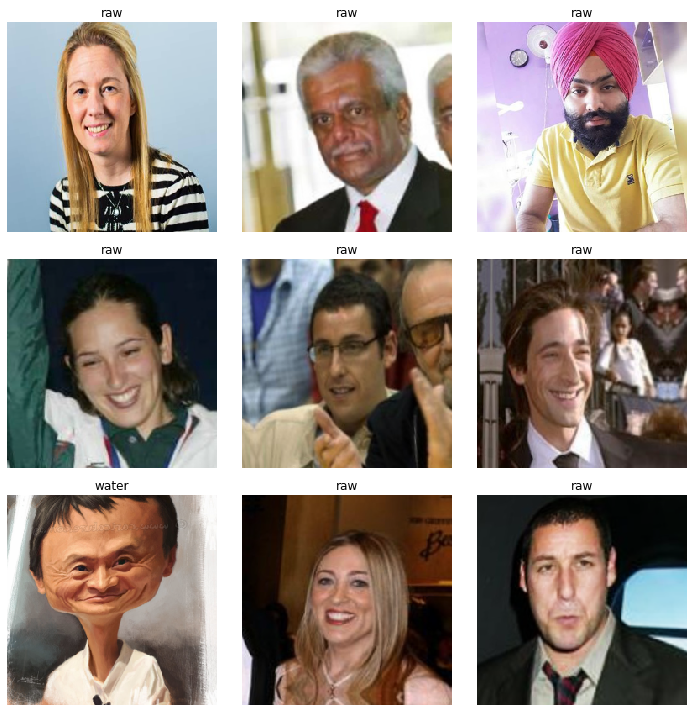

In [0]:
data.show_batch(rows=3, figsize=(10,10))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, pretrained=True)

I asked the Convolutional Learner to receive the data we prepared, and the architecture will be a pre-trained model called resnet34, then to measure if it learned well, the metrics will be the accuracy.

In [0]:
learn.unfreeze() # must be done before calling lr_find

Above code unfreezes all the layers of resnet architecture so we can train it on our own data.

In [0]:
learn.lr_find()

This runs the model for 25 epochs and starts increasing the learnings rate and plots a graph between loss and learning rate.

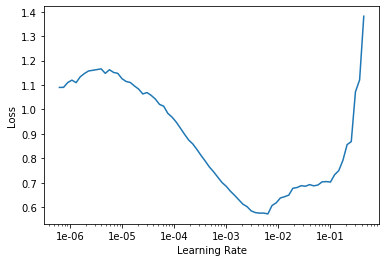

In [0]:
learn.recorder.plot()

We can see from above graph that learning rate is decreasing from 1e-5 till it reraches 1e-3. After this, its starts to explode. So, I keep the learning rate between these two values for training.

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

Above code (fit_one_cycle) used a concept called one-cycle-policy.
This varies the learning rate and momentum after each cycle so as to reach the minima in the least time.
I have reached a validation accuracy of around 90%, which is pretty good considering I had very less number of images to train.

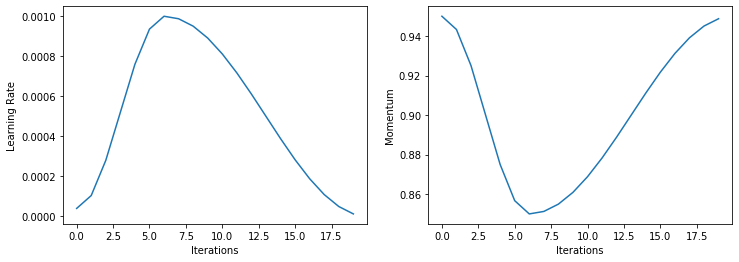

In [0]:
learn.recorder.plot_lr(show_moms=True)

Above plots show the change in learning rate and the momentum with the change in iterations.
Now, I will save this model.

In [0]:
learn.save('model_fastai_250_5')

In [0]:
learn.load('model_fastai_250_5')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

This plots the confusion matrix showing the hits and misses on validation data.

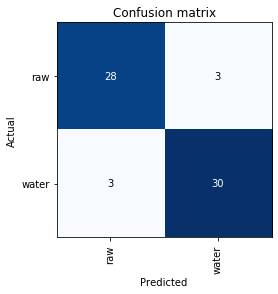

In [0]:
interp.plot_confusion_matrix()

Now, below code shows the top losses in our dataset.

In [0]:
interp.plot_top_losses(9, figsize=(15,15))

Let's use our learned model to make predictions on our test set.

Prediction: water


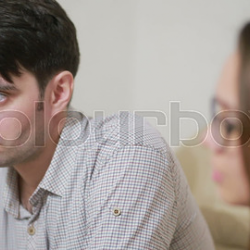

In [0]:
img = data.test_ds[61][0]
pred = learn.predict(img)[0]
print('Prediction:' , pred)
img

Now we are using our test dataset as validation set and make the predictions.

In [0]:
data_test = ImageDataBunch.from_folder(path, train = 'train', valid = 'test',ds_tfms=get_transforms(), size=250, num_workers=4).normalize(imagenet_stats)

In [0]:
data_test.valid_ds

LabelList (71 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/data

In [0]:
defaults.device = torch.device('cuda') # makes sure the gpu is used

In [0]:
learn_test = cnn_learner(data_test, models.resnet34, metrics=accuracy, pretrained=True)

In [0]:
learn_test.load('model_fastai_250_5')

In [0]:
interp_test = ClassificationInterpretation.from_learner(learn_test)

Below is the confusion matrix for test set.

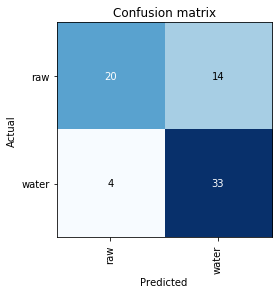

In [0]:
interp_test.plot_confusion_matrix()

In [0]:
learn_test.validate()

[0.7359245, tensor(0.7465)]

Model is validated on the test set, where accuracy is around 75%.
Below are the predictions and the ground truth for the test images.

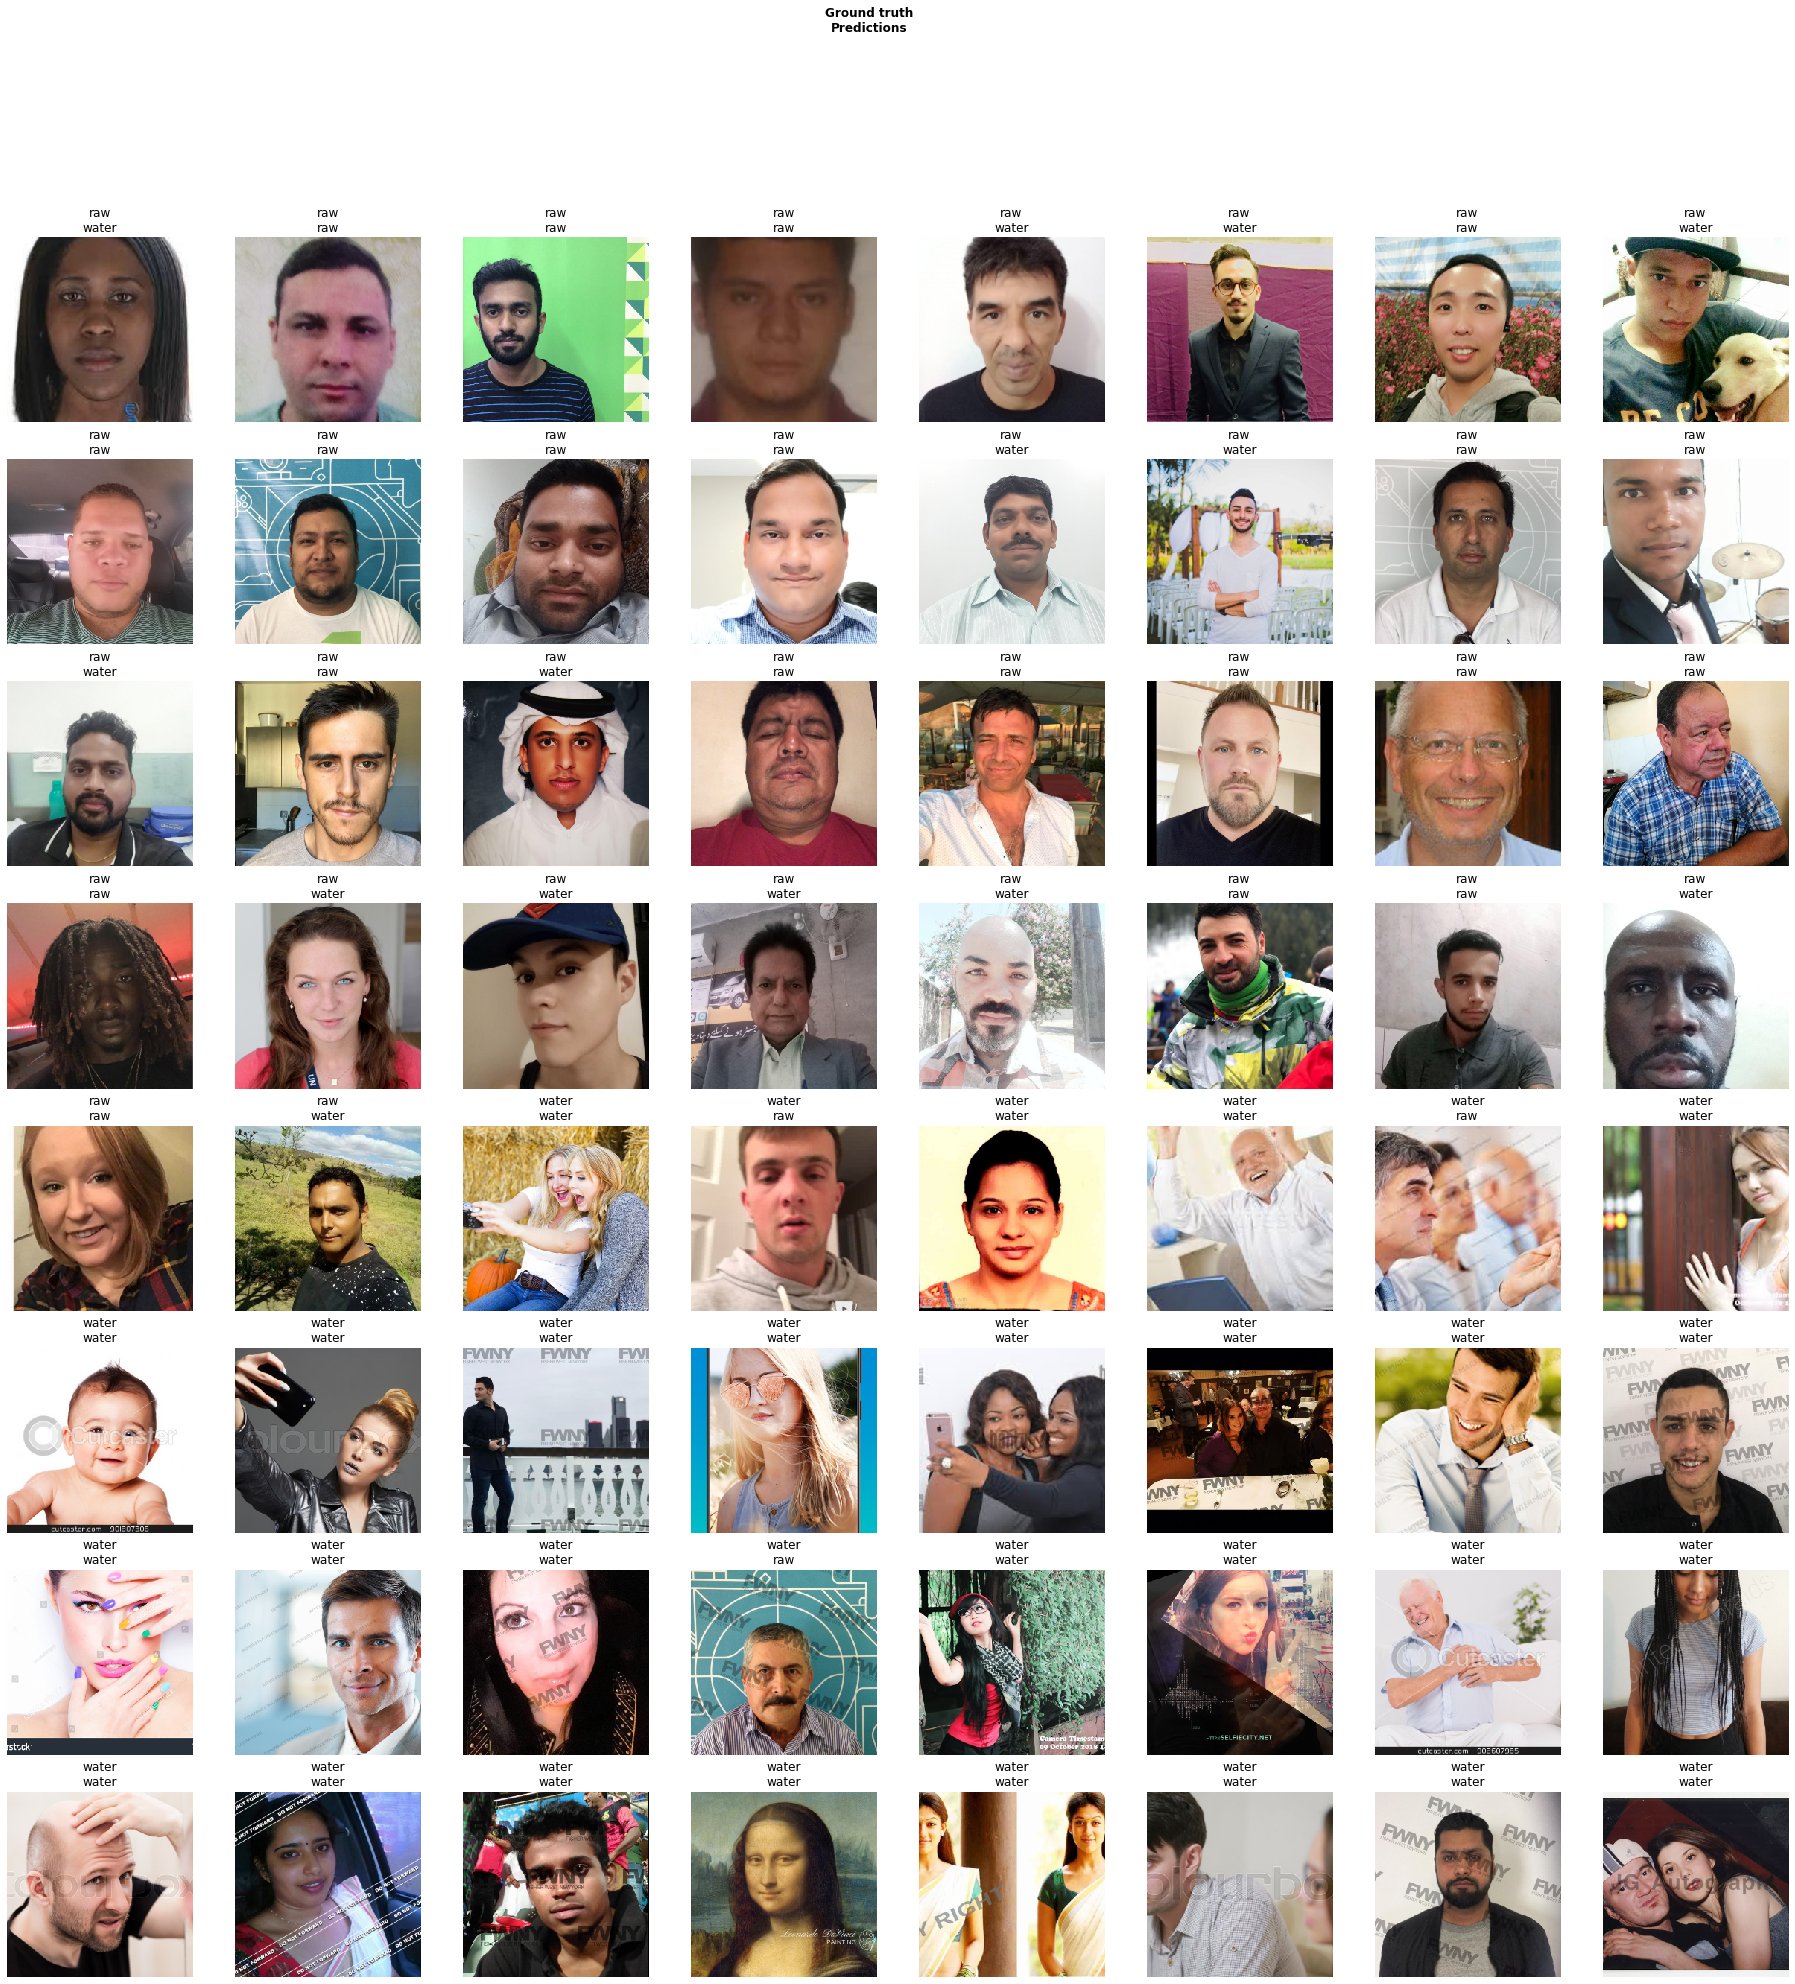

In [0]:
learn_test.show_results(rows=10)

So, my test accuracy is lower than the training and validation accuracy. This means that the model is overfitting the training data.
Since the dataset was also having very less images, performance of the model is still good. 
Further improvements will be tried by changing parameters like image size, epcohs, batch size, etc.